In [ ]:
%matplotlib inline
%load_ext memory_profiler

import pandas as pd
import os
import glob
import pickle
import phate
import scprep
import graphtools as gt
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time
import datetime
import scanpy as sc
import math
from scipy import sparse
import sys
sys.path.append('/home/ngr4/project/scripts/')
import utils
import magic

# settings
plt.rc('font', size = 9)
plt.rc('font', family='sans serif')
plt.rcParams['pdf.fonttype']=42
plt.rcParams['ps.fonttype']=42
plt.rcParams['text.usetex']=False
plt.rcParams['legend.frameon']=False
plt.rcParams['axes.grid']=False
plt.rcParams['legend.markerscale']=0.5
sc.set_figure_params(dpi=300,dpi_save=600,
                     frameon=False,
                     fontsize=9)
plt.rcParams['savefig.dpi']=600
sc.settings.verbosity=2
sc._settings.ScanpyConfig.n_jobs=-1
sns.set_style("ticks")



In [2]:
%%memit

pdfp = '/home/ngr4/project/scnd/data/processed'
pfp = '/home/ngr4/project/scnd/results/'
sc.settings.figdir = pfp

wt = utils.load_adata(os.path.join(pdfp,'mouse_wt_imputed.h5ad'))
# mut = utils.load_adata(os.path.join(pdfp,'mouse_sca1_imputed.h5ad'))

loaded @210120.13:08:08
took 36.84-s to load data
peak memory: 38653.79 MiB, increment: 38446.87 MiB


In [7]:
x = pd.read_csv(os.path.join(pfp, 'imp_corr_wt_nonzero.csv'), index_col=0)

In [17]:
xprime = x.loc[x['P']> 0.05]
xprime['abs_rho'] = xprime['rho'].abs()
xprime.sort_values(by='abs_rho').head(n=20)

<ipython-input-17-ef7f979fd41a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  xprime['abs_rho'] = xprime['rho'].abs()


,rho,P,abs_rho
Olfr921,0.000000,1.0000,0.000000
Ferd3l,0.000000,1.0000,0.000000
Gm29090,0.000000,1.0000,0.000000
Gm45431,0.000000,1.0000,0.000000
Upk2,0.000000,1.0000,0.000000
Gm14199,0.000000,1.0000,0.000000
Olfr361,0.000000,1.0000,0.000000
Serpina6,0.000000,1.0000,0.000000
Gm33570,0.000000,1.0000,0.000000
Gm37419,0.000000,1.0000,0.000000


# Data imputation concerns

Concenrs over artifacts introduced by MAGIC

## Benchmarking MAGIC

Need to validate, computationally, with whatever normally would do (see van Dijk original manuscript)

### imputed and raw expression correlation

Question about zeros, so maybe try without? Then, see what it is about poorly correlating genes that make them poorly correlation (see how they fit into differnetial expression groups of cell types, or whether their expression is correlated with noise or some other data quality metric)

Alternatively, could just do Kendall's tau-b, which is adapted to handl ties ([see this post](https://stackoverflow.com/questions/10711395/spearman-correlation-and-ties))

#### excluding 0s

In [19]:
%%memit 

tic = time.time()
from scipy.stats import spearmanr
rho, p = np.zeros((wt.shape[1],)), np.zeros((wt.shape[1],)) 
X = np.asarray(wt.X.todense()) # memory intensive
for i in range(wt.shape[1]):
    # check where that gene is >0 counts
    nonzero_idx = np.asarray((wt.raw[:, i].X>0).todense()).flatten()
    if np.sum(nonzero_idx) == 0: 
        #continue; else:
        print('No counts for {}'.format(wt.var_names[i]))
    rho[i], p[i] = spearmanr(X[nonzero_idx, i], wt.layers['imputed'][nonzero_idx, i], nan_policy='raise')
    if i % 200 == 0 and i!=0:
        print('{:.2f}-s elapsed\tthrough {:.2f}-% of iterations'.format(time.time() - tic, 100*(i/wt.shape[1])))
toc = time.time()
    
print('Correlations in {:.2f}-min'.format((toc-tic)/60))

No counts for Gm5524
88.62-s elapsed	through 0.76-% of iterations
166.15-s elapsed	through 1.52-% of iterations
243.32-s elapsed	through 2.27-% of iterations
319.93-s elapsed	through 3.03-% of iterations
397.63-s elapsed	through 3.79-% of iterations
No counts for Gm33994
474.78-s elapsed	through 4.55-% of iterations
551.18-s elapsed	through 5.31-% of iterations
No counts for Gm33973
628.50-s elapsed	through 6.07-% of iterations
No counts for Il1f5
705.46-s elapsed	through 6.82-% of iterations
782.35-s elapsed	through 7.58-% of iterations
859.94-s elapsed	through 8.34-% of iterations
No counts for Prg3
936.83-s elapsed	through 9.10-% of iterations
No counts for Olfr1065
No counts for Olfr1082
No counts for Olfr1135
No counts for Olfr142
1013.21-s elapsed	through 9.86-% of iterations
1089.84-s elapsed	through 10.62-% of iterations
1167.12-s elapsed	through 11.37-% of iterations
1244.06-s elapsed	through 12.13-% of iterations
No counts for Bpifb3
1320.51-s elapsed	through 12.89-% of itera

In [20]:
results_wt = pd.DataFrame({'rho':rho, 'P':p}, index=wt.var_names.to_list())
results_wt.to_csv(os.path.join(pfp, 'imp_corr_wt_nonzero.csv'))

#### including 0s

In [ ]:
# using kendall's tau-b
%%memit 

tic = time.time()
from scipy.stats import kendalltau
rho, p = np.zeros((wt.shape[1],)), np.zeros((wt.shape[1],)) 
X = np.asarray(wt.X.todense()) # memory intensive
for i in range(wt.shape[1]):
    rho[i], p[i] = kendalltau(X[:, i], wt.layers['imputed'][:, i])
    if i % 750 == 0 and i!=0:
        print('{:.2f}-s elapsed\tthrough {:.2f}-% of iterations'.format(time.time() - tic, 100*(i/wt.shape[1])))
toc = time.time()
    
print('Correlations in {:.2f}-min'.format((toc-tic)/60))

In [ ]:
results_wt = pd.DataFrame({'rho':rho, 'P':p}, index=wt.var_names.to_list())
results_wt.to_csv(os.path.join(pfp, 'imp_kendalltau_wt.csv'))

In [3]:
%%memit 

tic = time.time()
from scipy.stats import spearmanr
rho, p = np.zeros((wt.shape[1],)), np.zeros((wt.shape[1],)) 
X = np.asarray(wt.X.todense()) # memory intensive
for i in range(wt.shape[1]):
    rho[i], p[i] = spearmanr(X[:, i], wt.layers['imputed'][:, i], nan_policy='raise')
toc = time.time()
    
print('Correlations in {:.2f}-min'.format((toc-tic)/60))

/gpfs/ycga/project/dijk/ngr4/conda_envs/py385dev/lib/python3.8/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


Correlations in 21.40-min
peak memory: 91099.12 MiB, increment: 16585.34 MiB


In [4]:
results_wt = pd.DataFrame({'rho':rho, 'P':p}, index=wt.var_names.to_list())
results_wt.to_csv(os.path.join(pfp, 'imp_corr_wt.csv'))

In [5]:
%%memit 

tic = time.time()
from scipy.stats import spearmanr
rho, p = np.zeros((mut.shape[1],)), np.zeros((mut.shape[1],)) 
X = np.asarray(mut.X.todense()) # memory intensive
for i in range(mut.shape[1]):
    rho[i], p[i] = spearmanr(X[:, i], mut.layers['imputed'][:, i], nan_policy='raise')
toc = time.time()
    
print('Correlations in {:.2f}-min'.format((toc-tic)/60))

results_mut = pd.DataFrame({'rho':rho, 'P':p}, index=mut.var_names.to_list())
results_mut.to_csv(os.path.join(pfp, 'imp_corr_mut.csv'))

Correlations in 20.03-min
peak memory: 106407.30 MiB, increment: 15308.00 MiB


<AxesSubplot:xlabel='rho', ylabel='Proportion'>

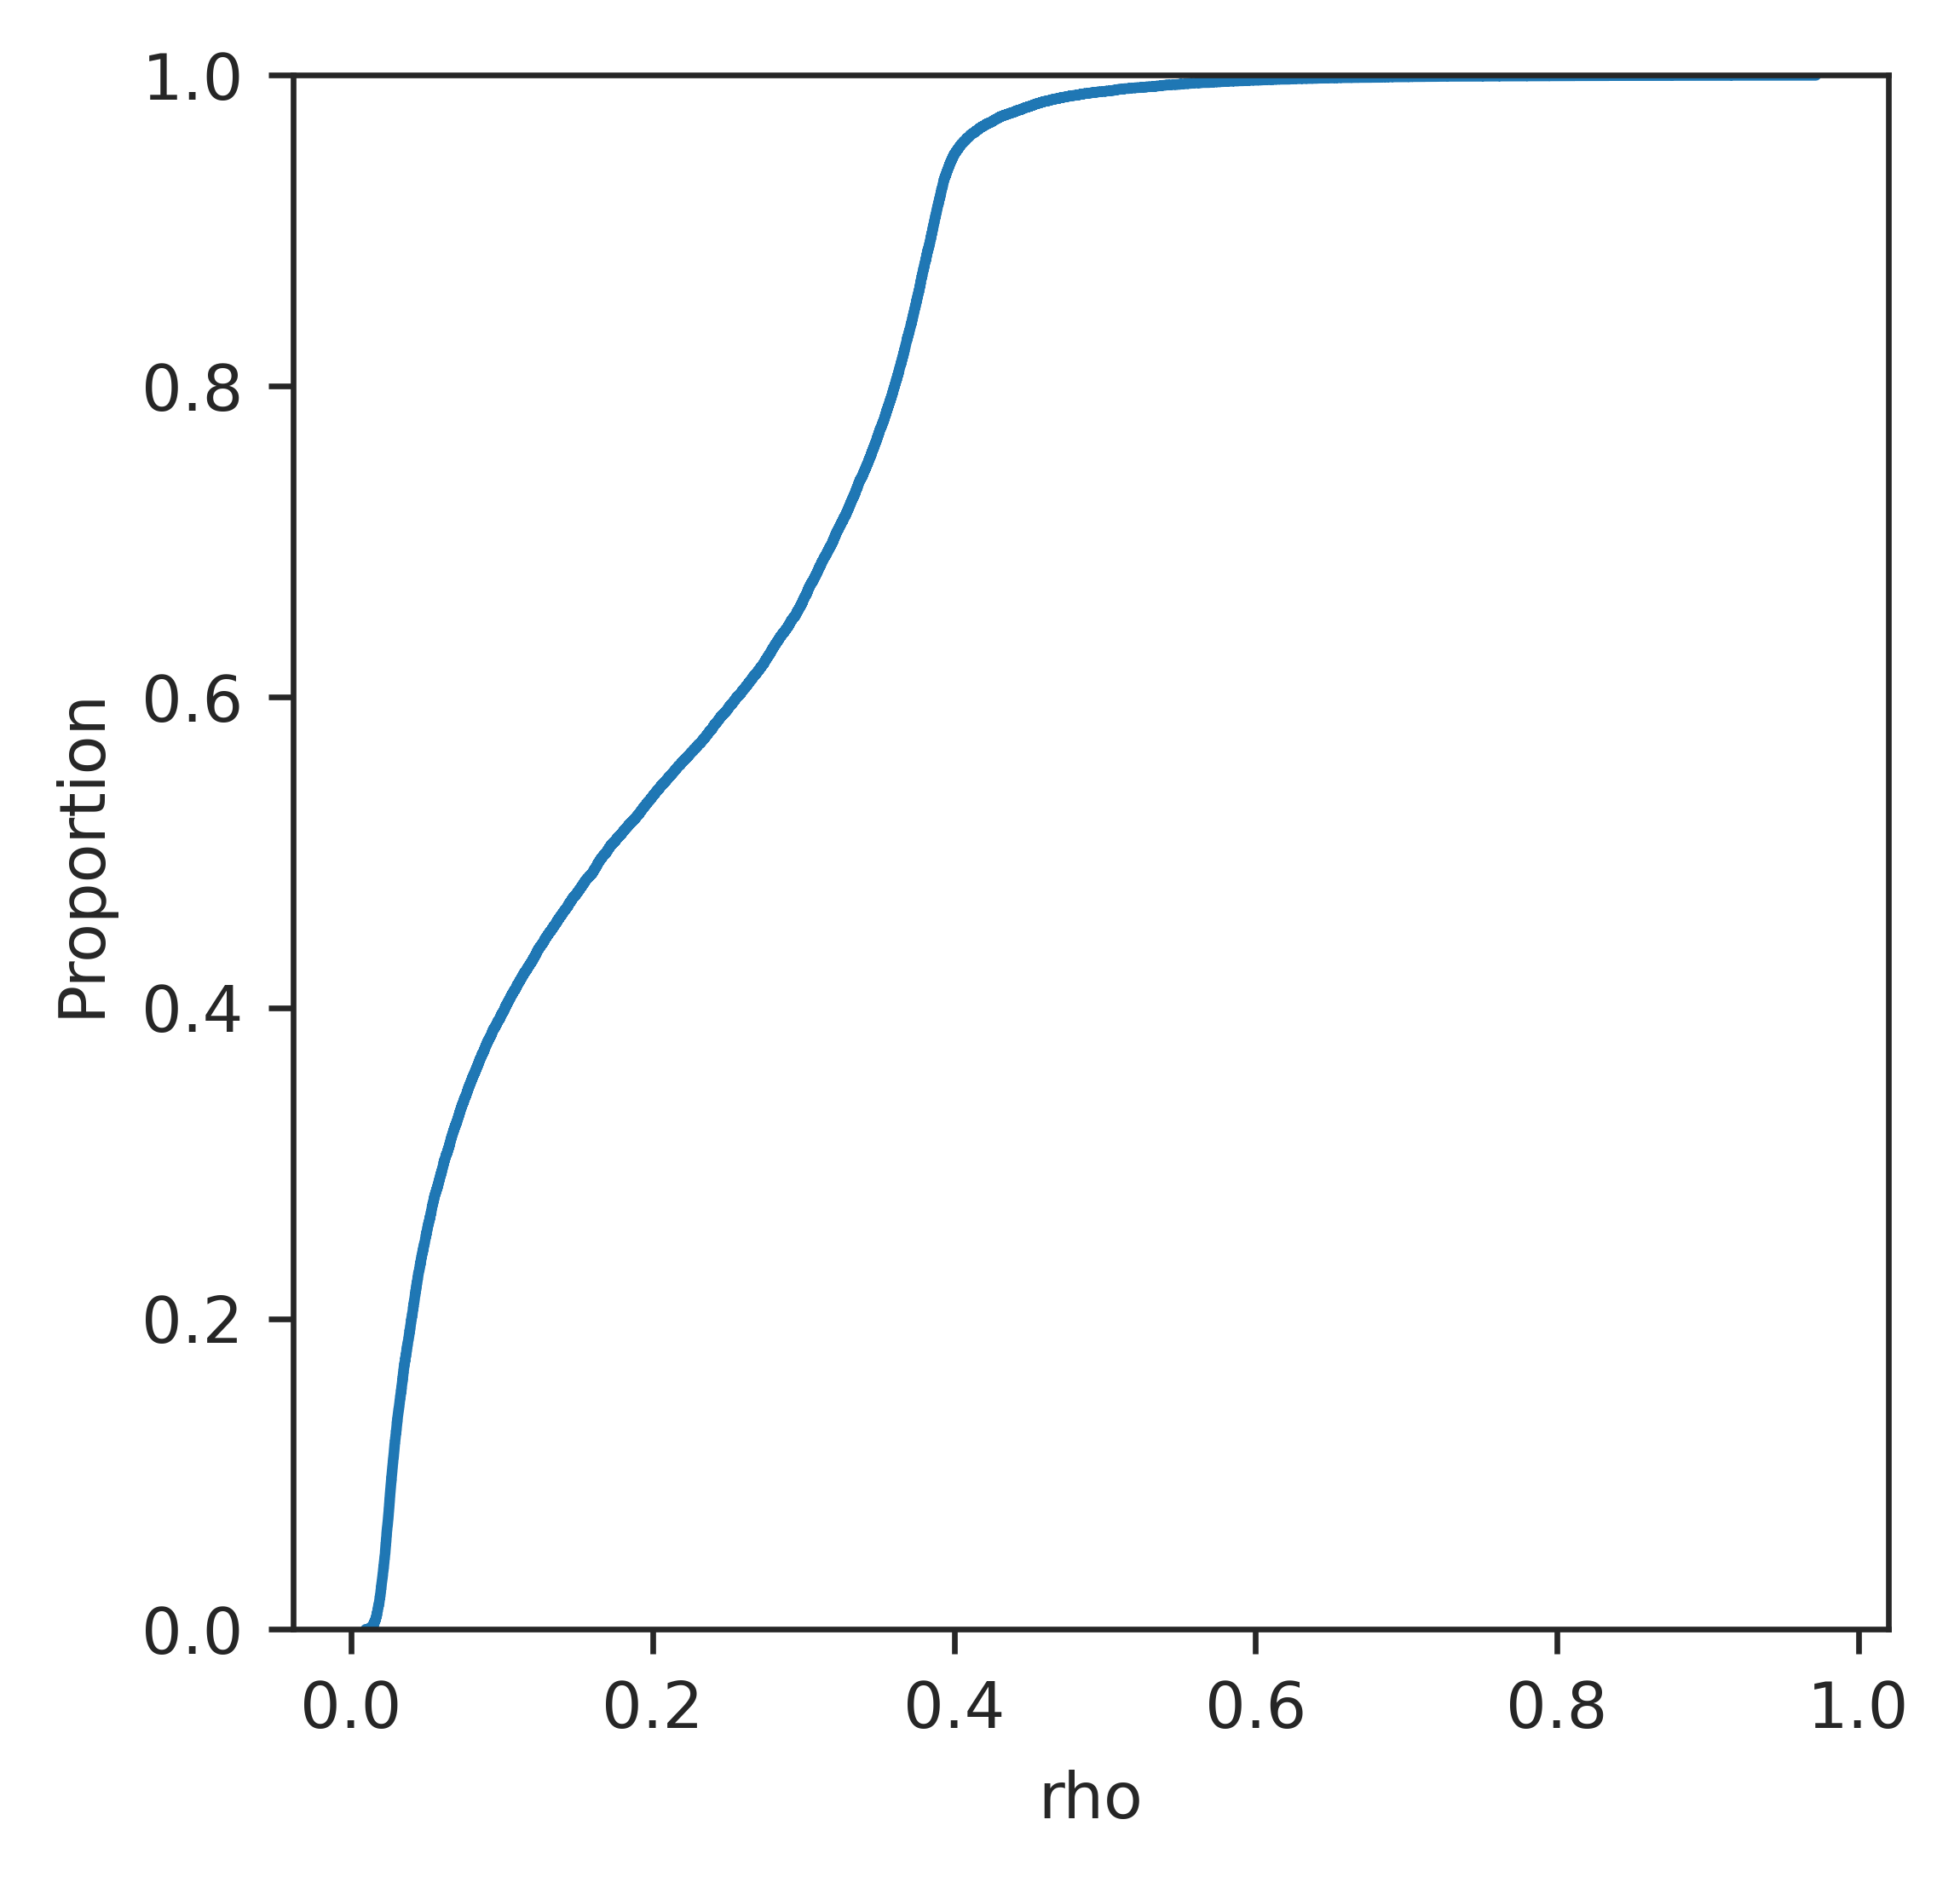

In [127]:
results_wt = pd.DataFrame({'rho':rho, 'P':p}, index=wt.var_names.to_list())

sns.ecdfplot(x='rho', data=results_wt)

In [10]:
results_wt['Genotype'] = 'WT'
results_wt['Gene'] = results_wt.index.to_list()
results_mut['Genotype'] = 'SCA1'
results_mut['Gene'] = results_mut.index.to_list()

results = results_wt.append(results_mut, ignore_index=True)
results['-log10P'] = results['P']
results['-log10P'].loc[results['P']==0] = results['P'].loc[results['P']!=0].min()
results['-log10P'] = -1 * np.log10(results['-log10P'])

/gpfs/ycga/project/dijk/ngr4/conda_envs/py385dev/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


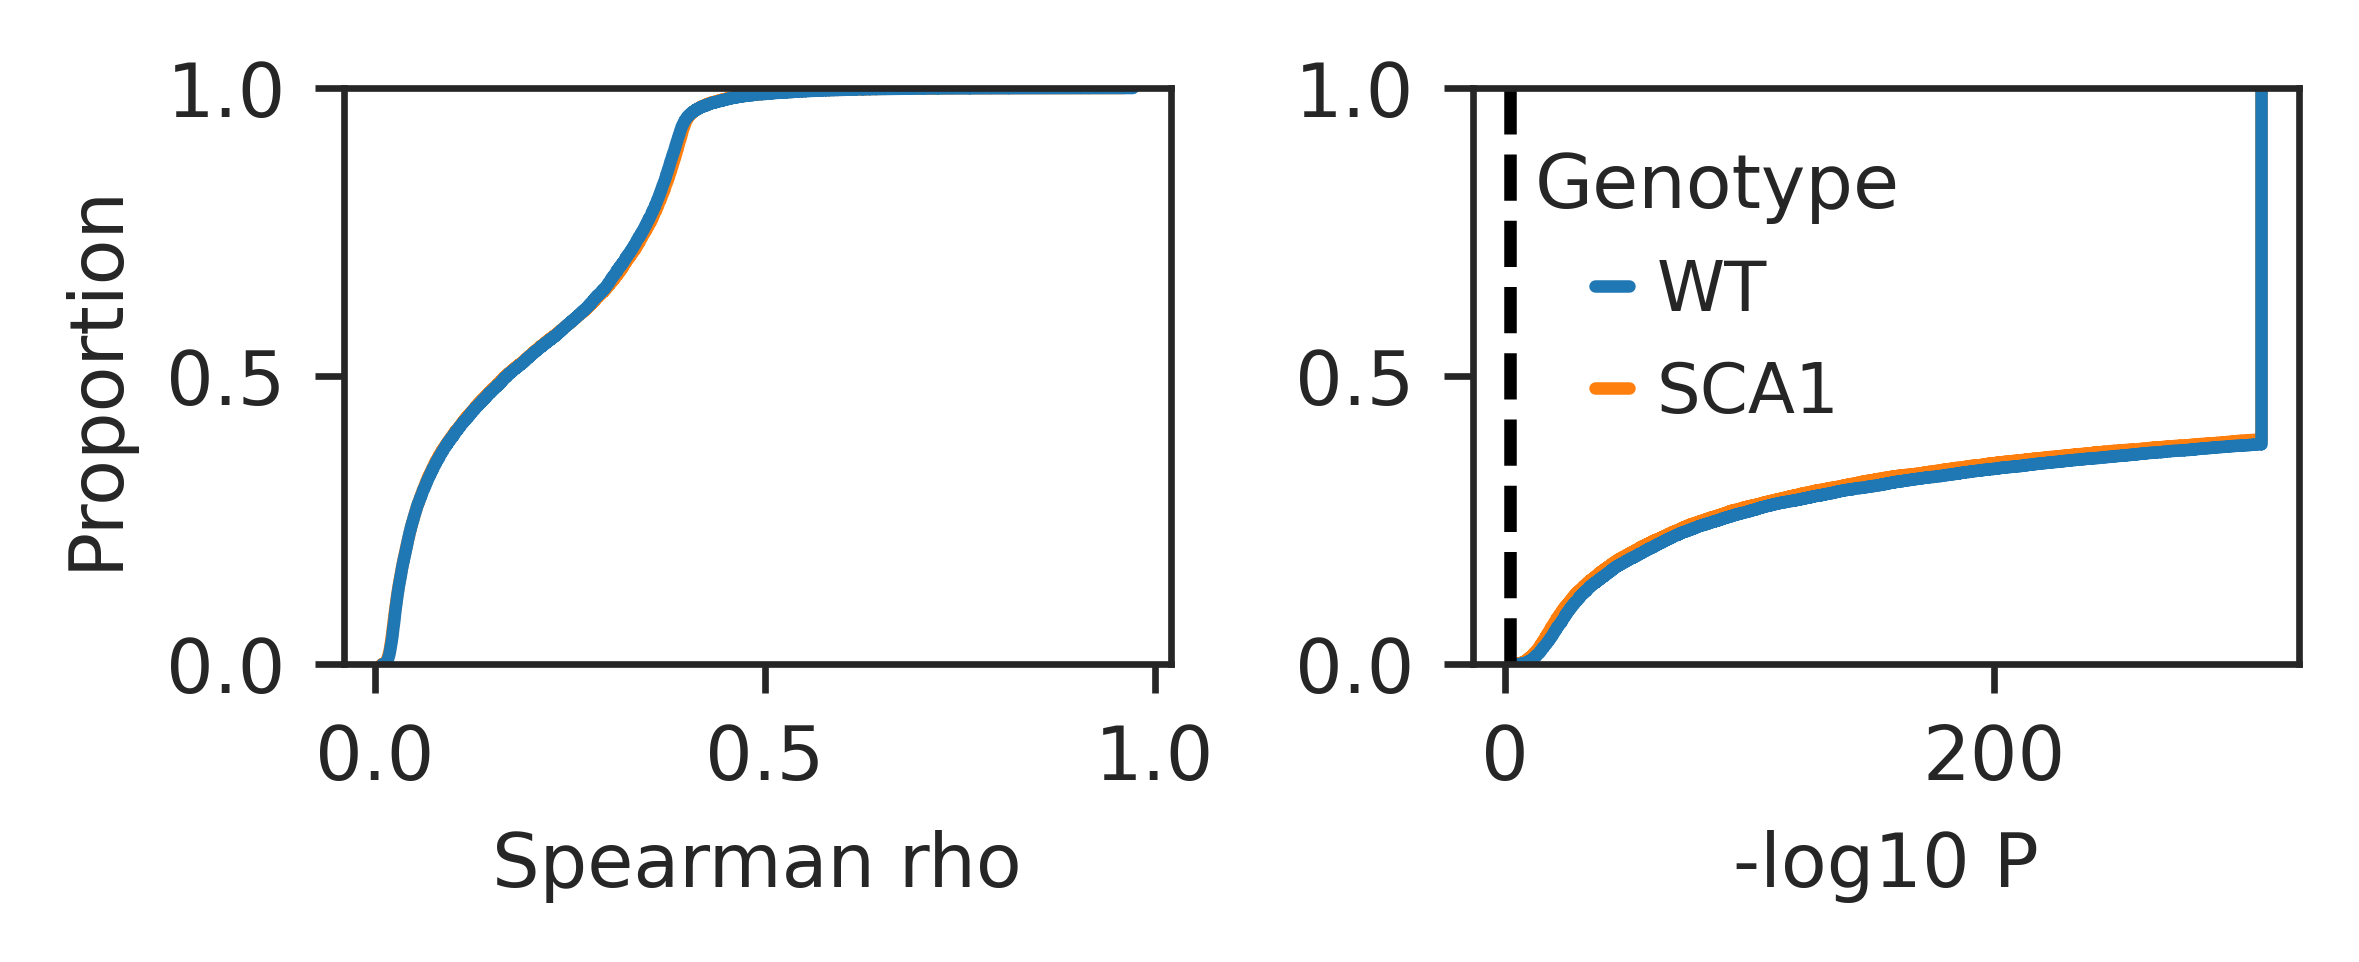

In [26]:
fig, ax = plt.subplots(1, 2, figsize=(4, 1.67))
sns.ecdfplot(x='rho', data=results, hue='Genotype', ax=ax[0], legend=False)
sns.ecdfplot(x='-log10P', data=results, hue='Genotype', ax=ax[1])
ax[0].set_xlabel('Spearman rho')
ax[1].plot([2,2], [ax[1].get_ylim()[0], ax[1].get_ylim()[1]], 'k--')
ax[1].set_xlabel('-log10 P')
ax[1].set_ylabel('')
fig.tight_layout()

<AxesSubplot:xlabel='Genotype', ylabel='-log10P'>

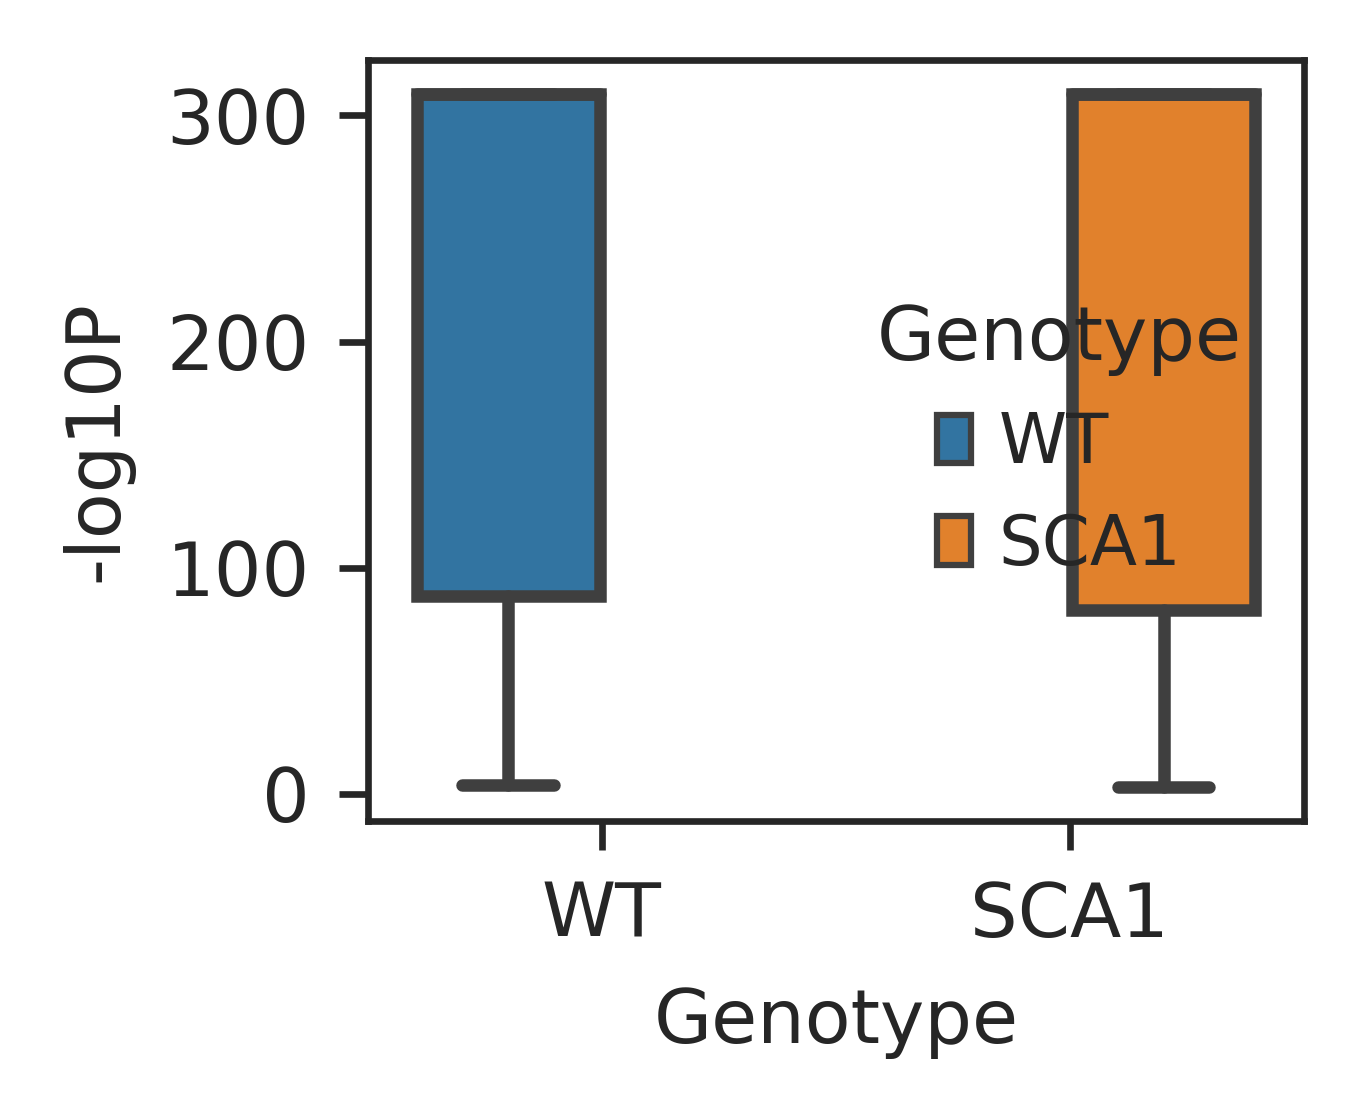

In [28]:
fig, ax = plt.subplots(1,1, figsize=(2,1.67))
sns.boxplot(x='Genotype', y='-log10P', data=results, hue='Genotype', ax=ax)


In [36]:
np.asarray(wt[:, 'Xkr4'].X.todense()).flatten().shape

(164722,)

In [43]:
results_wt.head()

,rho,P,Genotype,Gene
Xkr4,0.535164,0.000000e+00,WT,Xkr4
Gm1992,0.383737,0.000000e+00,WT,Gm1992
Gm37381,0.058955,9.669012e-127,WT,Gm37381
Rp1,0.169754,0.000000e+00,WT,Rp1
Sox17,0.127944,0.000000e+00,WT,Sox17


/gpfs/ycga/project/dijk/ngr4/conda_envs/py385dev/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


Text(0.5, 1.0, 'Xkr4')

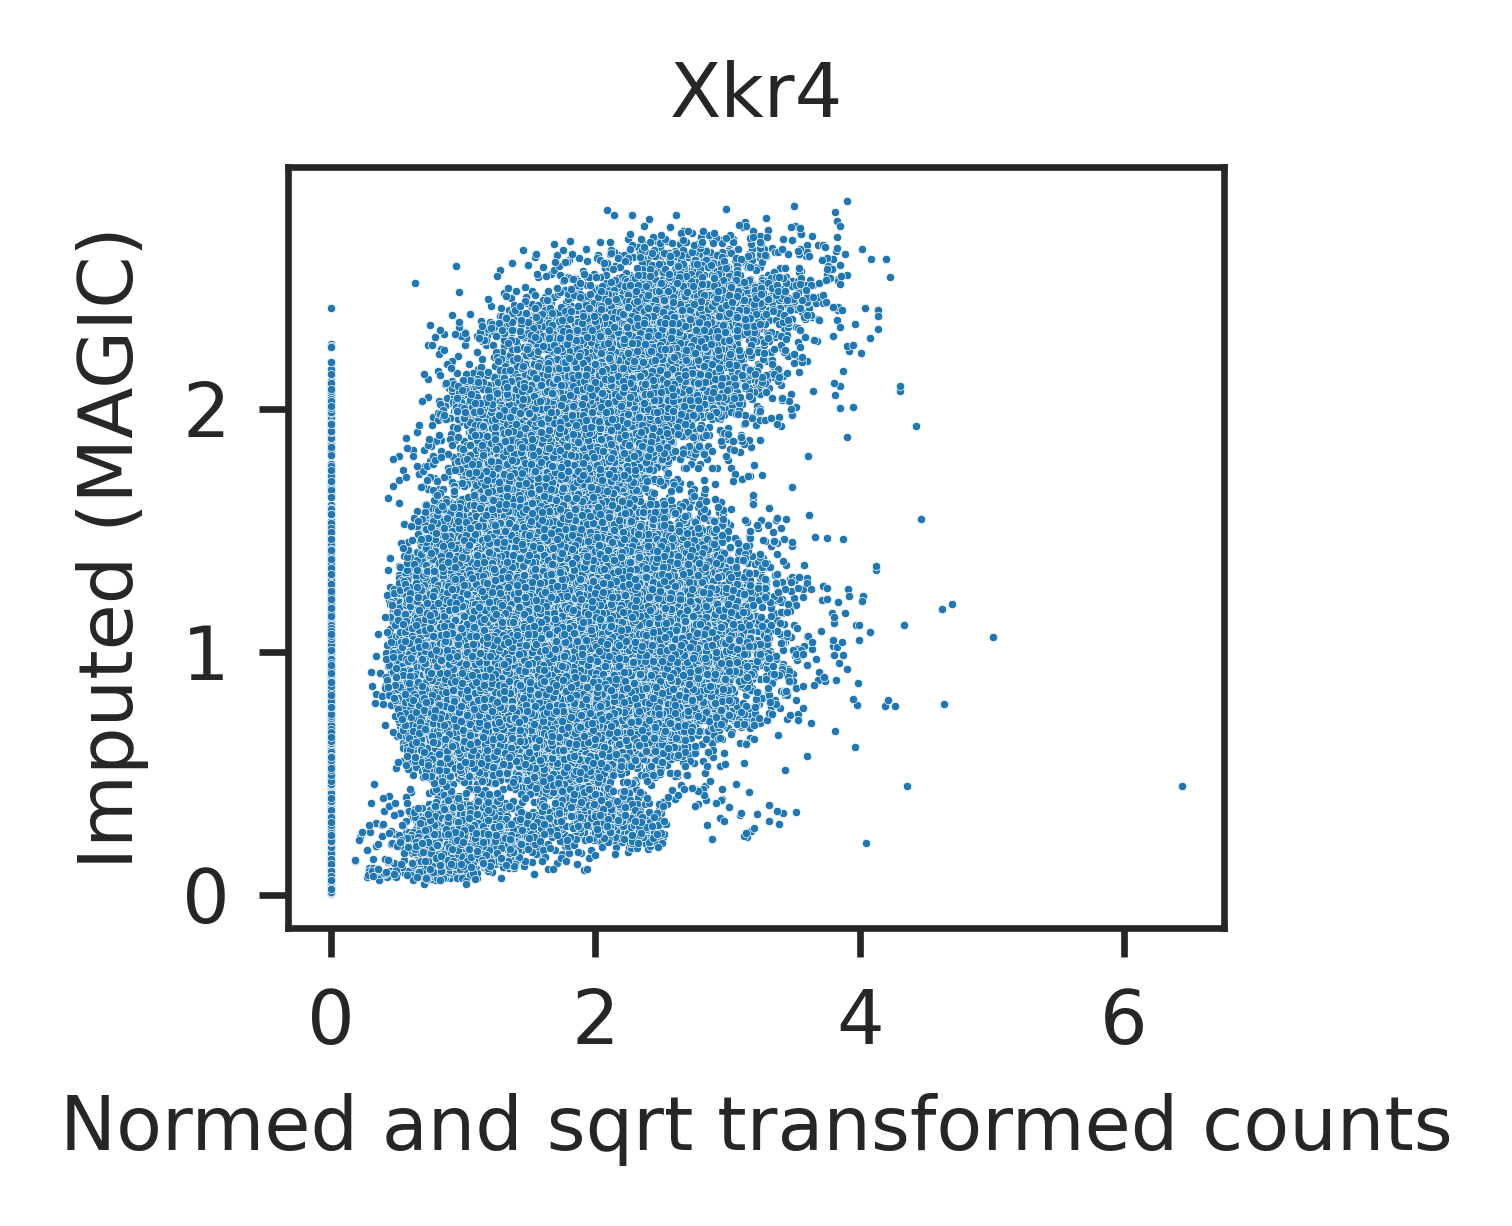

In [44]:
g = 'Xkr4'
fig, ax = plt.subplots(1,1, figsize=(2,1.67))
sns.scatterplot(x=np.asarray(wt[:, g].X.todense()).flatten(), 
                y=np.asarray(wt[:, g].layers['imputed']).flatten(),
                lw=0, s=1,
               ax=ax)
ax.set_xlabel('Normed and sqrt transformed counts')
ax.set_ylabel('Imputed (MAGIC)')
ax.set_title(g)

In [48]:
X = np.asarray(wt[0:2000, :].X.todense())
Xprime = np.asarray(wt[0:2000, :].layers['imputed'])

In [50]:
Xprime

array([[1.83202338e-01, 2.57069946e-03, 1.20239341e-03, ...,
        8.39039091e-01, 6.58203191e-02, 2.01742926e-02],
       [1.12667037e+00, 1.01855253e-01, 0.00000000e+00, ...,
        4.03259298e-01, 1.03413278e-02, 1.24549727e-03],
       [1.02500330e-01, 3.86869081e-03, 1.58965139e-04, ...,
        8.29832329e-01, 5.89320931e-02, 0.00000000e+00],
       ...,
       [9.21769217e-01, 8.89148586e-02, 4.43122088e-04, ...,
        9.19038363e-01, 5.90923784e-02, 2.37929284e-03],
       [1.01148715e+00, 7.95929984e-02, 1.13143588e-03, ...,
        9.28798799e-01, 2.62044592e-02, 3.12081374e-03],
       [1.92492302e+00, 3.30191103e-01, 5.18933629e-04, ...,
        1.18109359e+00, 3.43556851e-02, 3.25348862e-03]])

/gpfs/ycga/project/dijk/ngr4/conda_envs/py385dev/lib/python3.8/site-packages/seaborn/matrix.py:659: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


KeyboardInterrupt: 

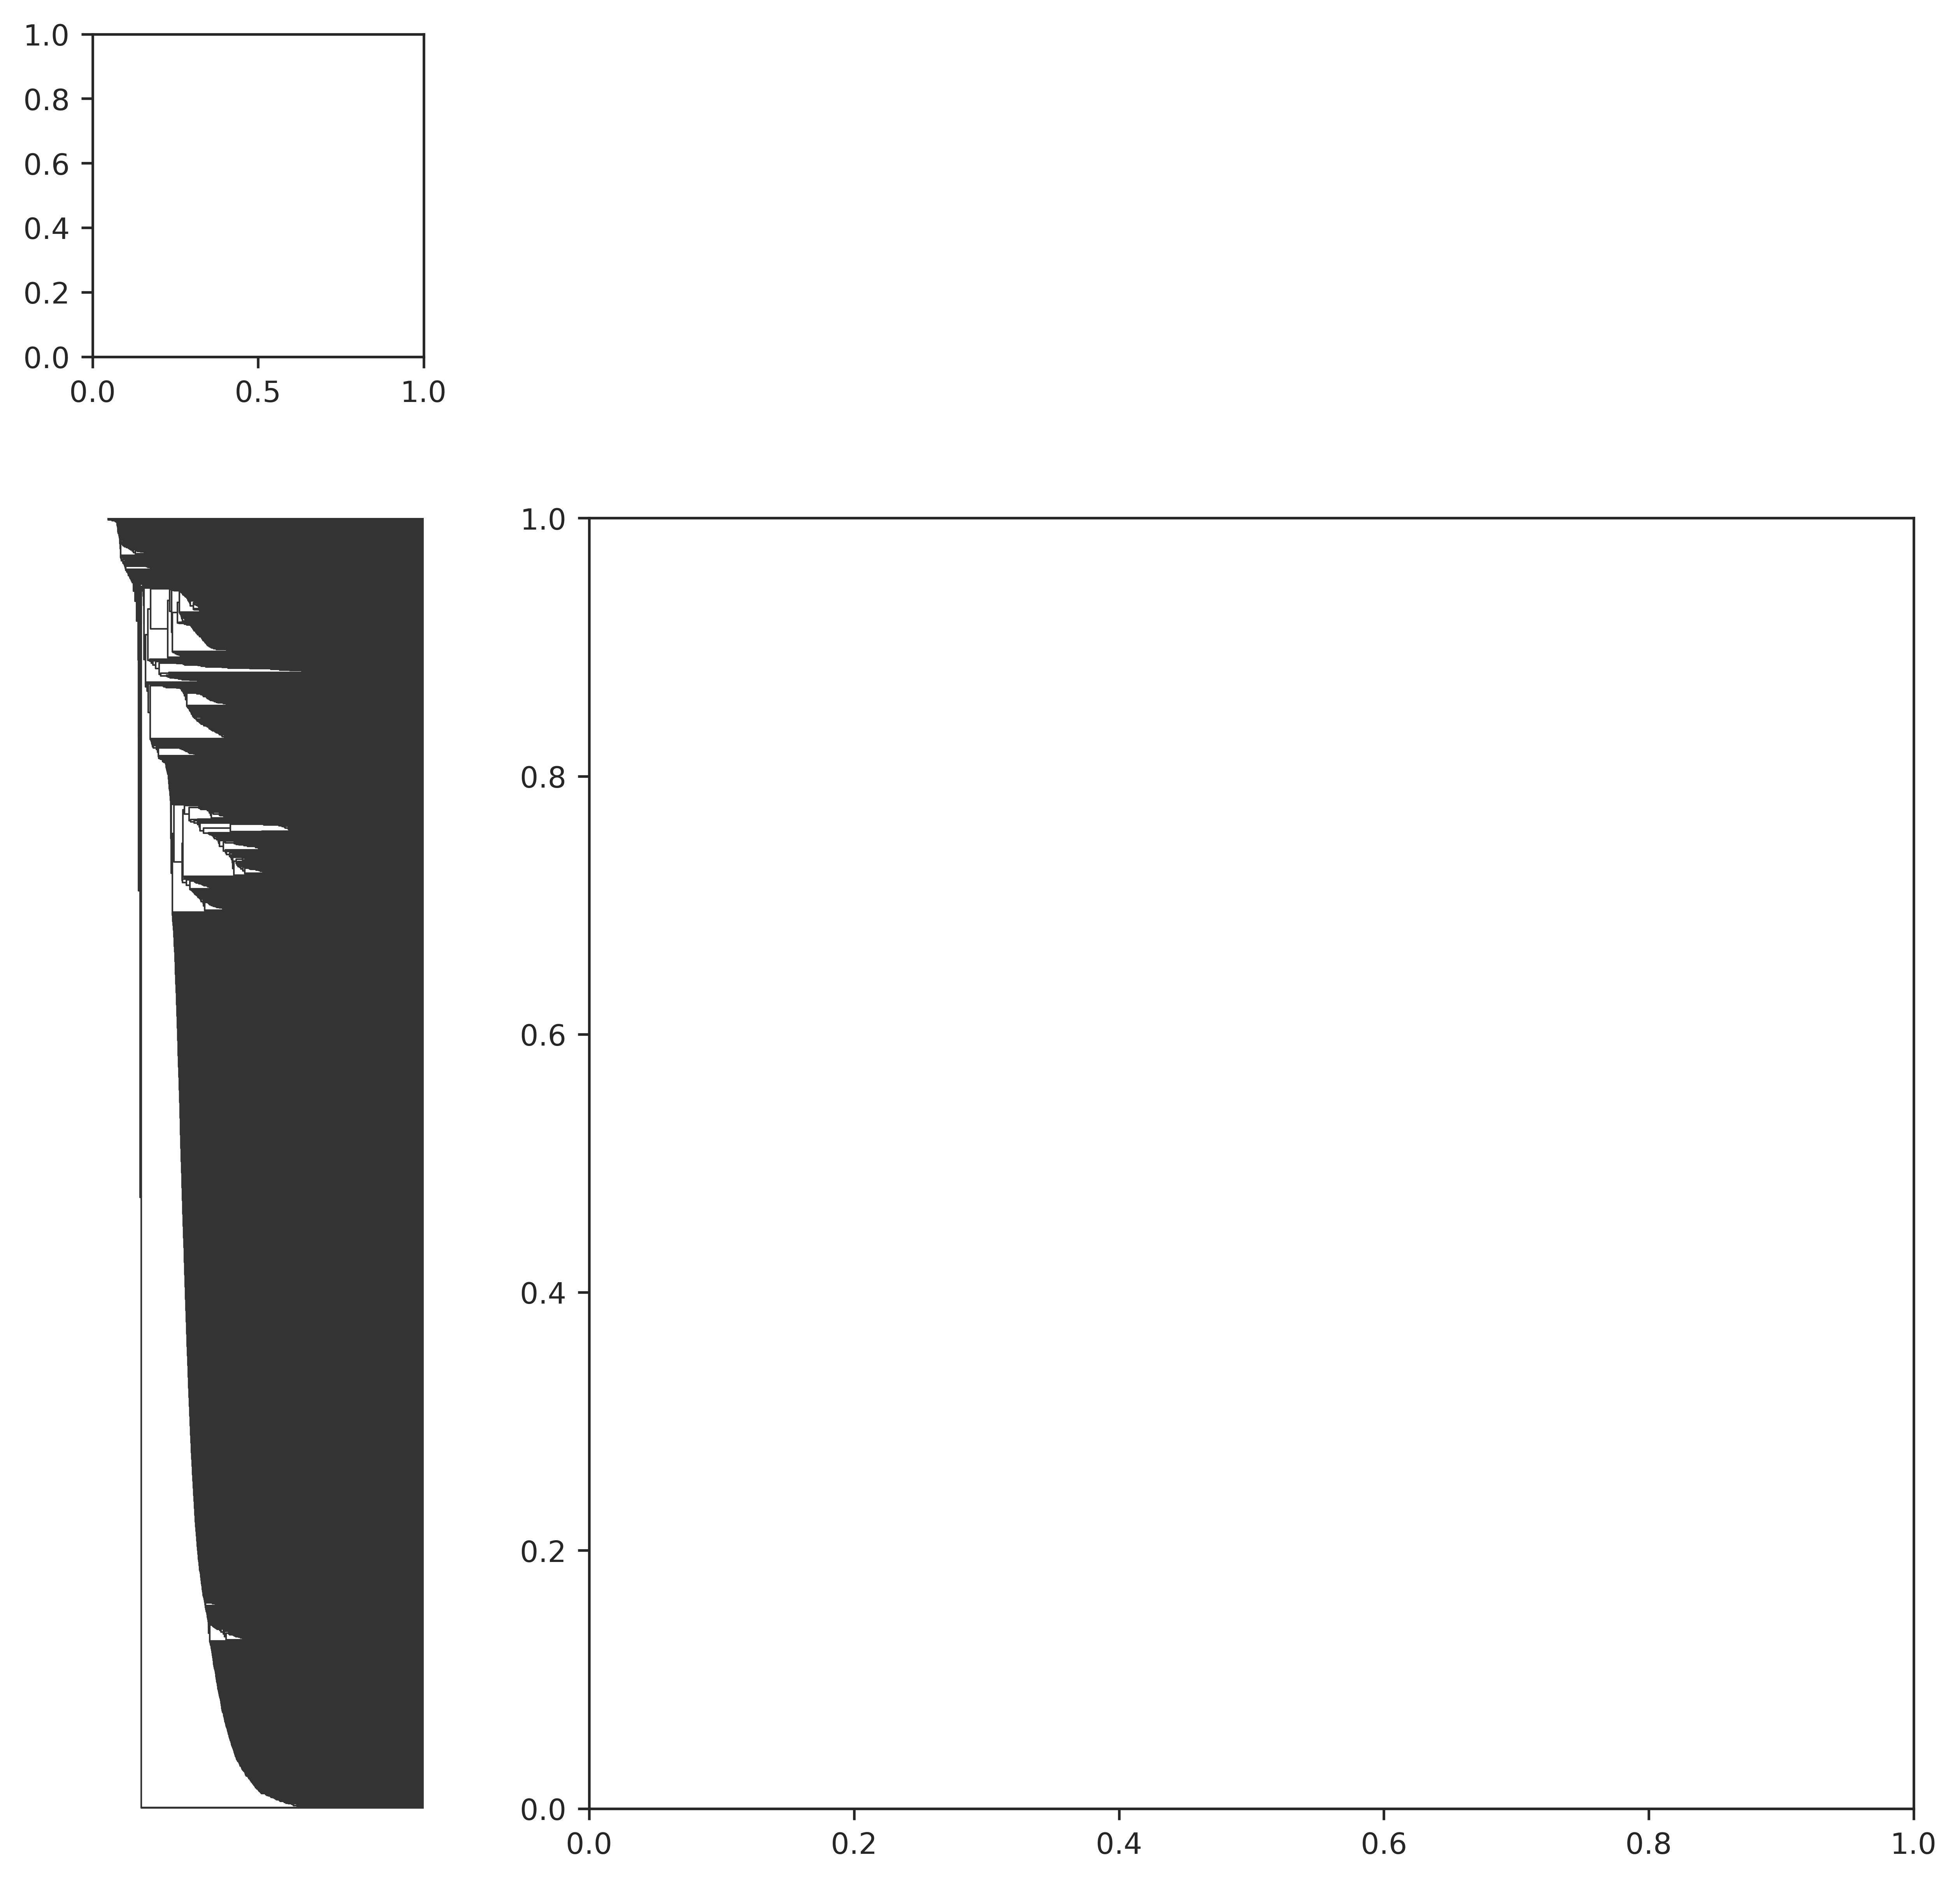

In [51]:
sns.clustermap(X, cmap='YlOrBr')

In [ ]:
sns.clustermap(Xprime, cmap='YlOrBr')

In [ ]:
!pip install fastcluster